<a href="https://colab.research.google.com/github/grgrbu/ML-bioinf/blob/main/HW3_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [2]:
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib

import math

from scipy.stats import entropy as st_entropy
from sklearn.model_selection import train_test_split

### Задание 1 (1 балл)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [3]:
def gini(x):
    labels_cnt = dict()
    for label in x:
        if label in labels_cnt.keys():
            labels_cnt[label] += 1
        else:
            labels_cnt[label] = 1
    gini_coeff = 0
    for label in labels_cnt.keys():
        p_label = labels_cnt[label] / len(x)
        gini_coeff += p_label * (1 - p_label)

    return gini_coeff
    
def entropy(x):
    return st_entropy(x, base = 2)

def gain(left_y, right_y, criterion):
    size_left = len(left_y)
    size_right = len(right_y)
    size_all = size_left + size_right
    
    Q = criterion(left_y + right_y) - (size_right/size_all) * criterion(right_y) - (size_left/size_all) * criterion(left_y)
    SplitInfo = 0
    
    labels_cnt = dict()
    for label in (left_y + right_y):
        if label in labels_cnt.keys():
            labels_cnt[label] += 1
        else:
            labels_cnt[label] = 1
    for label in labels_cnt.keys():
        p_label = labels_cnt[label] / len(x)
        SplitInfo -= p_label * math.log(p_label, 2)
    
    return Q / SplitInfo

In [4]:
x = [0, 0, 0, 1, 1, 1, 1]
gini(x)
entropy(x)
gain([1, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 1], gini)

-0.0

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [5]:
class DecisionTreeLeaf:
    def __init__(self, y = None):
        self.y = y
        self.probs = dict()

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
        

### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [6]:
def make_split(X, y, min_size, critetion):
    n = len(X)
    m = len(X[0])
    max_gain = -1e6
    split_dim = -1
    split_value = 0
    for dim in range(m):
        for value in X[:, dim]:
            left_y, right_y = [], []
            for i in range(len(X)):
                if X[i][dim] < value:
                    left_y.append(y[i])
                else:
                    right_y.append(y[i])
            
            if len(left_y) >= min_size and len(right_y) >= min_size:  
                cur_gain = gain(left_y, right_y, critetion)
                if cur_gain > max_gain:
                    max_gain = cur_gain
                    split_dim = dim
                    split_value = value
                
    return split_dim, split_value

In [7]:
def make_node(tree, X, y, depth):
    new_node = None
        
    if len(y) == 0: # no data in the group
        return None
    if np.all(y == y[0]): # every label is the same in the group
        return DecisionTreeLeaf(y[0])
    if depth < 0: # depth limit reached
        return DecisionTreeLeaf(np.bincount(y).argmax())

    if tree.criterion == "gini":
        split_dim, split_value = make_split(X, y, tree.min_samples_leaf, gini)
    else:
        split_dim, split_value = make_split(X, y, tree.min_samples_leaf, entropy)
    if split_dim == -1:
        return DecisionTreeLeaf(np.bincount(y).argmax())

    X_left = X[X[:, split_dim] < split_value]
    X_right = X[X[:, split_dim] >= split_value]
    y_left = y[X[:, split_dim] < split_value]
    y_right = y[X[:, split_dim] >= split_value]

    return DecisionTreeNode(split_dim, split_value
                            , make_node(tree, X_left, y_left, depth - 1), make_node(tree, X_right, y_right, depth - 1))

In [24]:
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.depth = 0
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.root = None
        
    
    def fit(self, X, y):
        self.root = make_node(self, X, y, self.max_depth)

        for i in range(len(X)):
            cur_node = self.root
            cur_X = X
            cur_y = y
            while type(cur_node) == DecisionTreeNode:
                if X[i][cur_node.split_dim] < cur_node.split_value:
                    cur_X = X[X[:, cur_node.split_dim] < cur_node.split_value]
                    cur_y = y[X[:, cur_node.split_dim] < cur_node.split_value]
                    cur_node = cur_node.left
                else:
                    cur_X = X[X[:, cur_node.split_dim] >= cur_node.split_value]
                    cur_y = y[X[:, cur_node.split_dim] >= cur_node.split_value]
                    cur_node = cur_node.right
            cur_prob = dict()
            for elem in cur_y:
                if elem in cur_prob.keys():
                    cur_prob[elem] += 1/len(cur_y)
                else:
                    cur_prob[elem] = 1/len(cur_y)
            cur_node.probs = cur_prob
        
        
    def predict_proba(self, X):
        prob_dicts_array = []
        for i in range(len(X)):
            cur_node = self.root
            while type(cur_node) == DecisionTreeNode:
                if X[i][cur_node.split_dim] < cur_node.split_value:
                    cur_node = cur_node.left
                else:
                    cur_node = cur_node.right
            
            prob_dicts_array.append(cur_node.probs)
        return prob_dicts_array
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [9]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [10]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Задание 4 (2 балла)

Протестируйте решение на данных cancer и spam (датасеты из директории `hw2_data`).
Выполните загрузку и предобработку данных.


Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.

Посчитайте метрики `precision`, `recall`, `accuracy` для модели дерева.
Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`). 

Какой нужен препроцессинг данных для моделей?
Какая модель делает предсказания лучше?  Предположите, почему.

_Первое дерево иногда стороится таким образом, что в вершинах оказываются одни единицы. Мне кажется, нужно выровнять размеры датасетов для 0 и 1, чтобы такого не было. Из-за этого и kNN работает лучше. Я ещё пробовал удалять все строки в Nan-элементами, но тогда их стаётся слишком мало (всего 6 в первом случае). Поэтому решил выбирать просто majority-branch, когда это было нужно._

In [11]:
from sklearn.metrics import accuracy_score, \
                            recall_score, precision_score

from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

In [12]:
CANCER_DATA_PATH = "/cancer.csv"
SPAM_DATA_PATH = "/spam.csv"

In [13]:
def read_cancer_dataset(path_to_csv):
    cancer_csv = pd.read_csv(path_to_csv)
    X = cancer_csv.values[:, 1:]
    y_bm = cancer_csv.values[:, 0]
    y = []
    for elem in y_bm:
        if elem == 'B':
            y.append(1)
        else:
            y.append(0)
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    return X, np.array(y)

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    spam_csv = pd.read_csv(path_to_csv)
    X = spam_csv.values[:, :-1]
    y = spam_csv.values[:, -1]

    return X, y

In [14]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

In [15]:
X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(X_cancer, y_cancer, shuffle = True)
X_spam_train, X_spam_test, y_spam_train, y_spam_test = train_test_split(X_spam, y_spam, shuffle = True)

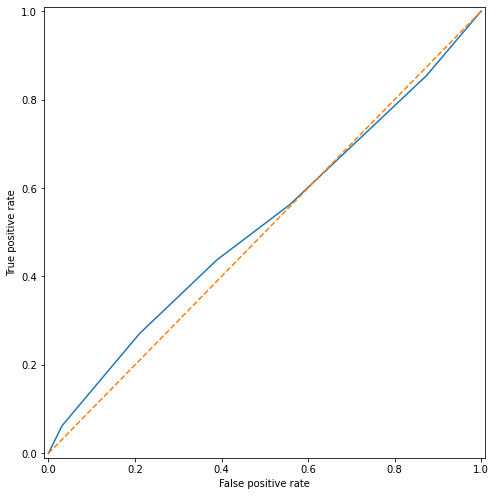

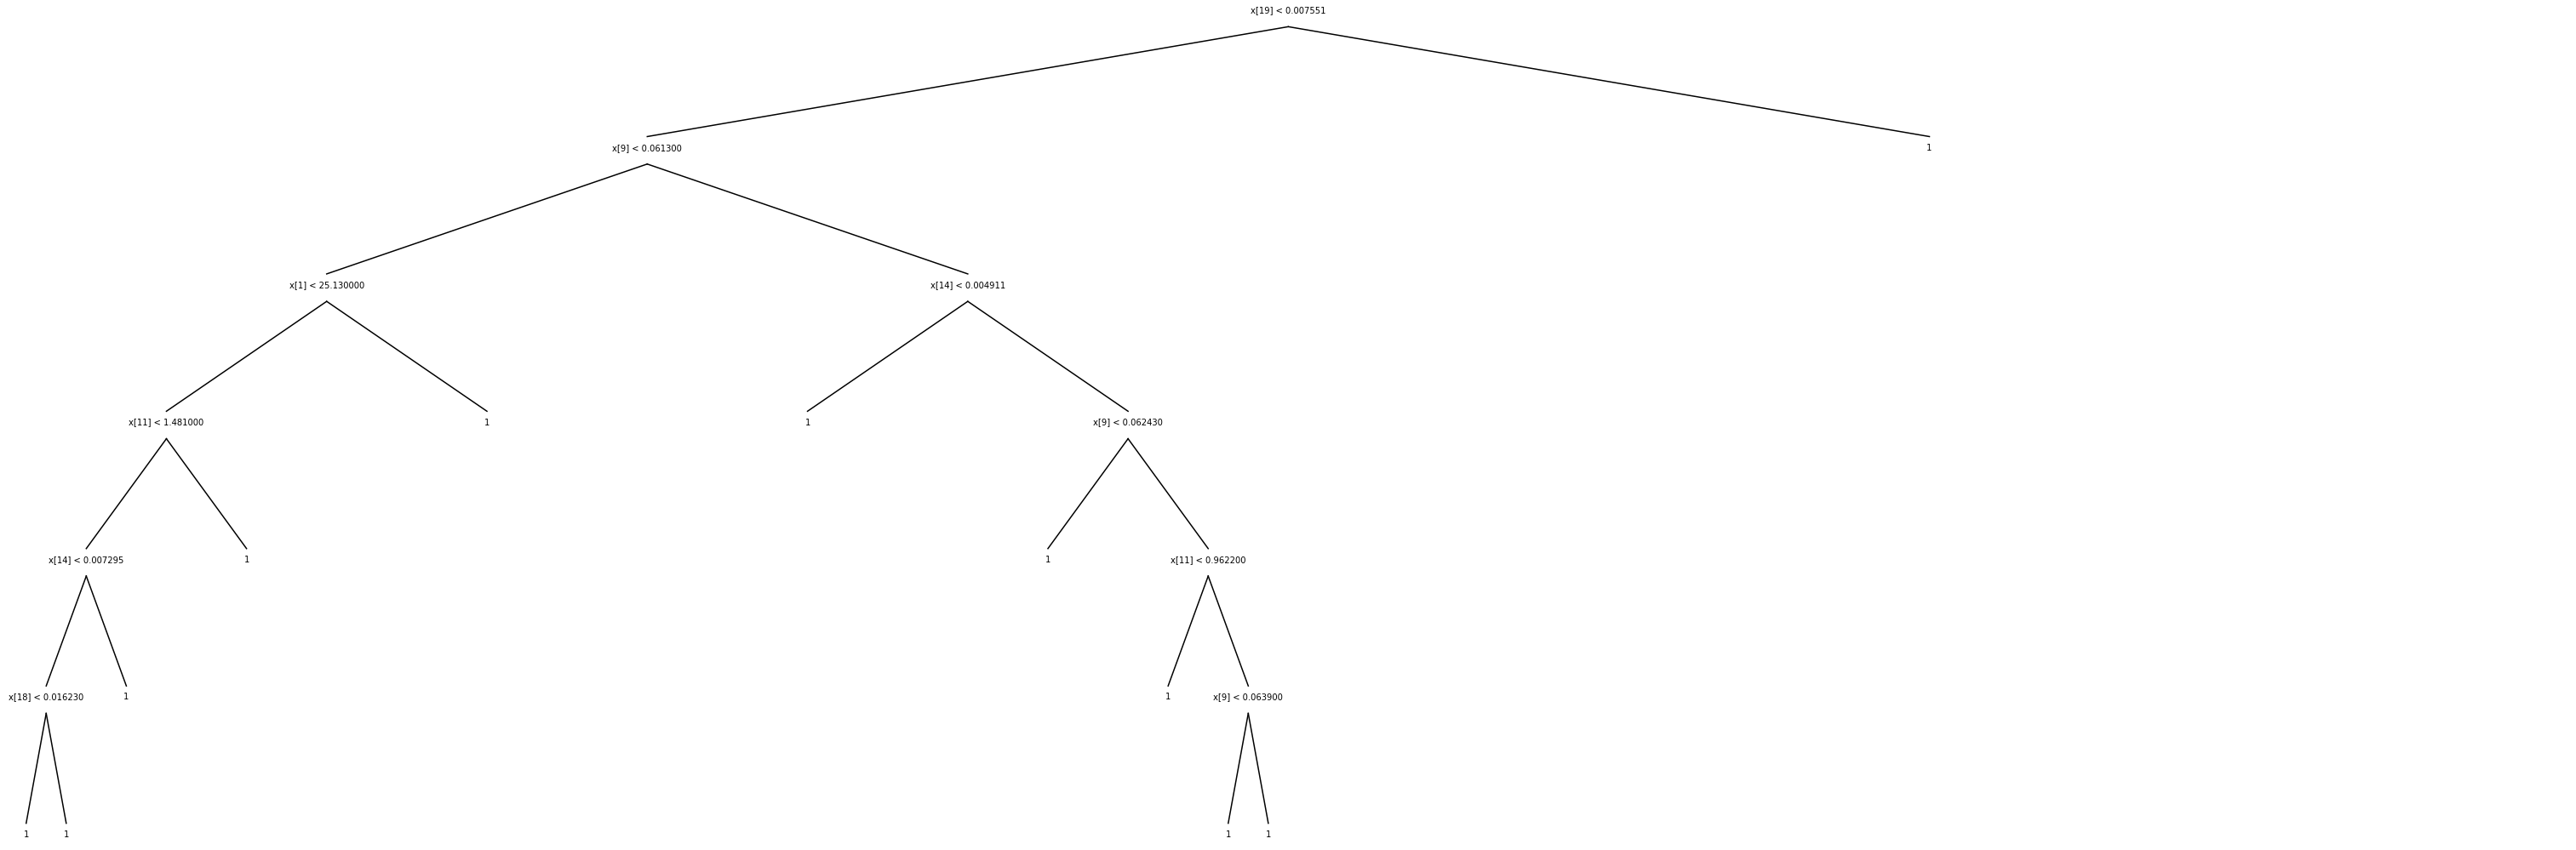

In [27]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20)
tree.fit(X_cancer_train, y_cancer_train)
plot_roc_curve(y_cancer_test, tree.predict_proba(X_cancer_test))
draw_tree(tree)

In [30]:
tree2 = KNeighborsClassifier(n_neighbors=5)
tree2.fit(X_cancer_train, y_cancer_train)

print(accuracy_score(y_cancer_test, tree.predict(X_cancer_test)), accuracy_score(y_cancer_test, tree2.predict(X_cancer_test)))
print(recall_score(y_cancer_test, tree.predict(X_cancer_test)), recall_score(y_cancer_test, tree2.predict(X_cancer_test)))
print(precision_score(y_cancer_test, tree.predict(X_cancer_test)), precision_score(y_cancer_test, tree2.predict(X_cancer_test)))

0.6643356643356644 0.9440559440559441
0.968421052631579 0.9894736842105263
0.6715328467153284 0.9306930693069307
